In [1]:
# Libraries
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



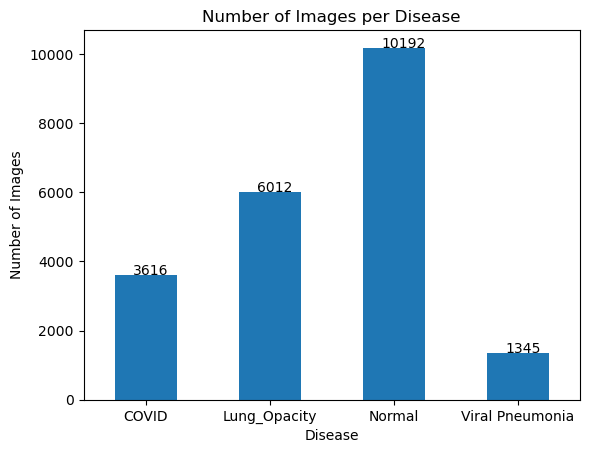

Training set size = 16932, Validation set size = 2116, Test set size = 2117


In [3]:
# Define the directory containing the COVID-19 radiography images
data_dir = '/Users/kysgattu/Desktop/ChestXRayClassification/COVID-19_Radiography_Dataset'

# Initialize two empty lists to store the image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse through all four folders of the dataset directory and map the files to their class names
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)

    if pathlib.Path(folder_path).suffix != '':
        continue

    if os.path.isdir(folder_path):
        file_list = os.listdir(folder_path)

        for file in file_list:
            file_path = os.path.join(folder_path, file)

            if os.path.isdir(file_path):
                if pathlib.Path(folder_path).suffix == '':
                    # Ignore the mask folders since they are not used
                    if pathlib.Path(file_path).parts[-1] in ['masks', 'Masks', 'MASKS']:
                        continue
                    else:
                        original_file_list = os.listdir(file_path)

                        for f in original_file_list:
                            img_path = os.path.join(file_path, f)
                            image_paths.append(img_path)
                            labels.append(folder)
                else:
                    image_paths.append(file_path)
                    labels.append(folder)

# Store the image file names and their corresponding class names in a Pandas DataFrame
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Visualize the number of images per class
label_counts = data_frame.groupby('labels')['image_paths'].count()
ax = label_counts.plot(kind='bar')

plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')
plt.xticks(rotation=0)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(i.get_height()), fontsize=10)

plt.show()

# Split the data into training, validation, and test sets at a ratio of 80-10-10
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

print(f'Training set size = {len(train_df)}, Validation set size = {len(valid_df)}, Test set size = {len(test_df)}')


In [7]:
# Determine the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length that are less than or equal to 80
factors = []
for n in range(1, test_length + 1):
    if test_length % n == 0 and test_length // n <= 80:
        factors.append(n)

# Select the largest factor as the test batch size
test_batch_size = max(sorted(factors, reverse=True))

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged
def identity(img):
    return img

# Create image data generators for the training, validation, and test datasets
train_augmentor = ImageDataGenerator(preprocessing_function=identity, horizontal_flip=True)
test_augmentor = ImageDataGenerator(preprocessing_function=identity)

train_gen = train_augmentor.flow_from_dataframe(
    train_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = test_augmentor.flow_from_dataframe(
    valid_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = test_augmentor.flow_from_dataframe(
    test_df,
    x_col='image_paths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [8]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)        

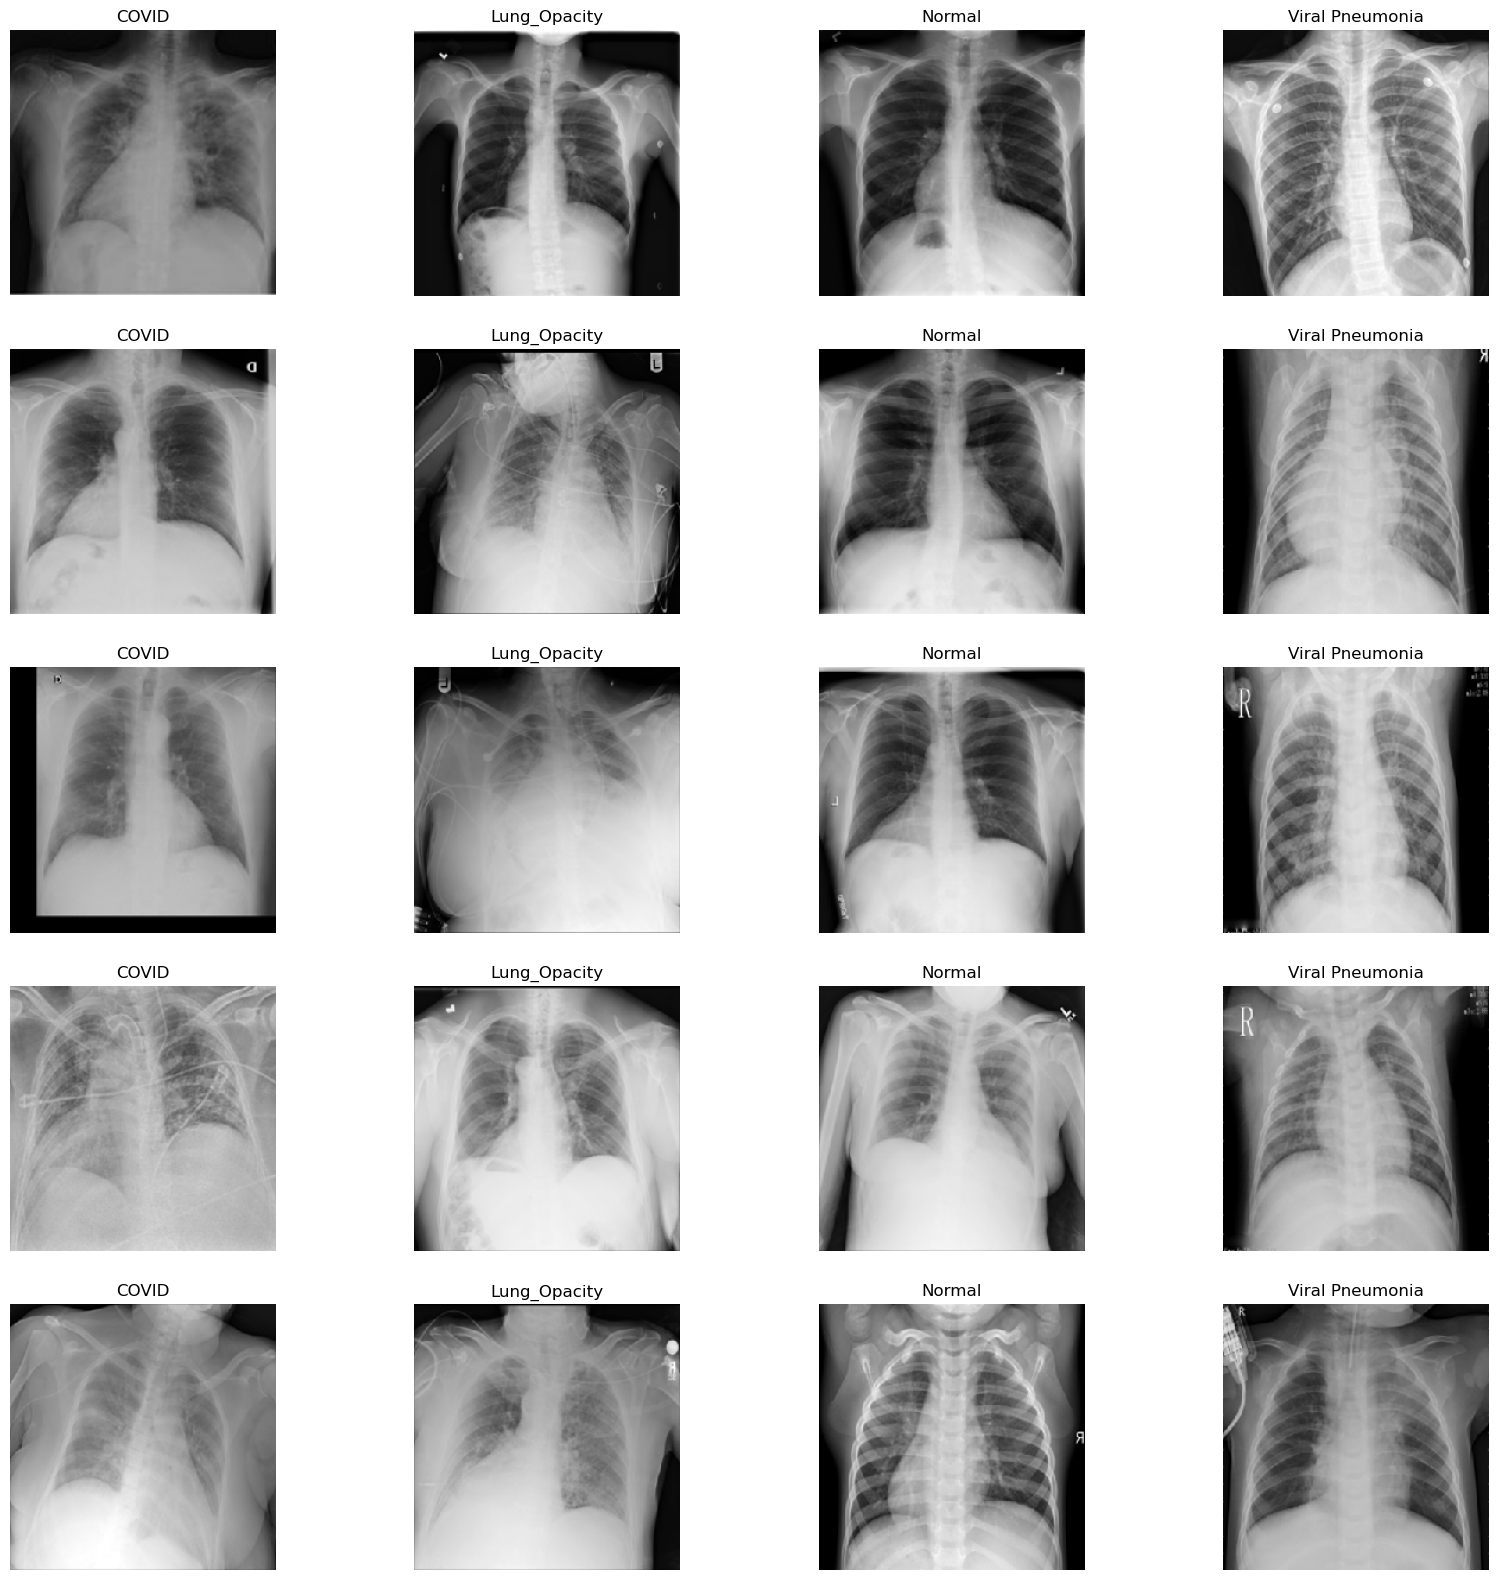

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()


In [10]:
# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)


# Define the LeNet model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Metal device set to: Apple M1 Pro


2023-04-19 21:06:08.771866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 21:06:08.772178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 32)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [13]:
# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    callbacks = early_stop,
    validation_data=valid_gen,)

Epoch 1/20


2023-04-19 21:06:23.042232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 21:06:23.249503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1058/1059 [============================>.] - ETA: 0s - loss: 10.8898 - accuracy: 0.6370

2023-04-19 21:07:13.141149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1059/1059 [==============================] - 54s 51ms/step - loss: 10.8803 - accuracy: 0.6370 - val_loss: 0.7424 - val_accuracy: 0.7042
Epoch 2/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.7971 - accuracy: 0.6722 - val_loss: 0.8378 - val_accuracy: 0.6371
Epoch 3/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.6738 - accuracy: 0.7210 - val_loss: 0.7269 - val_accuracy: 0.7027
Epoch 4/20
1059/1059 [==============================] - 52s 49ms/step - loss: 0.5699 - accuracy: 0.7703 - val_loss: 0.7596 - val_accuracy: 0.6905
Epoch 5/20
1059/1059 [==============================] - 53s 50ms/step - loss: 0.5309 - accuracy: 0.7853 - val_loss: 0.7536 - val_accuracy: 0.6966
Epoch 6/20
1059/1059 [==============================] - 52s 50ms/step - loss: 0.4469 - accuracy: 0.8271 - val_loss: 0.7279 - val_accuracy: 0.7443
Epoch 7/20
1059/1059 [==============================] - 53s 50ms/step - loss: 0.3683 - accuracy: 0.8595 - val_loss: 0.7845 - val_accur

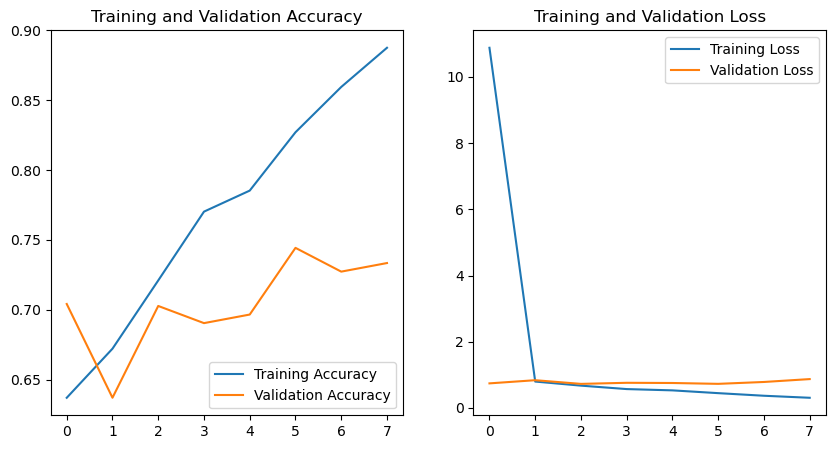

In [14]:
# Plot the training and validation accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #Change with the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
model.save('LeNet_Saved.h5')

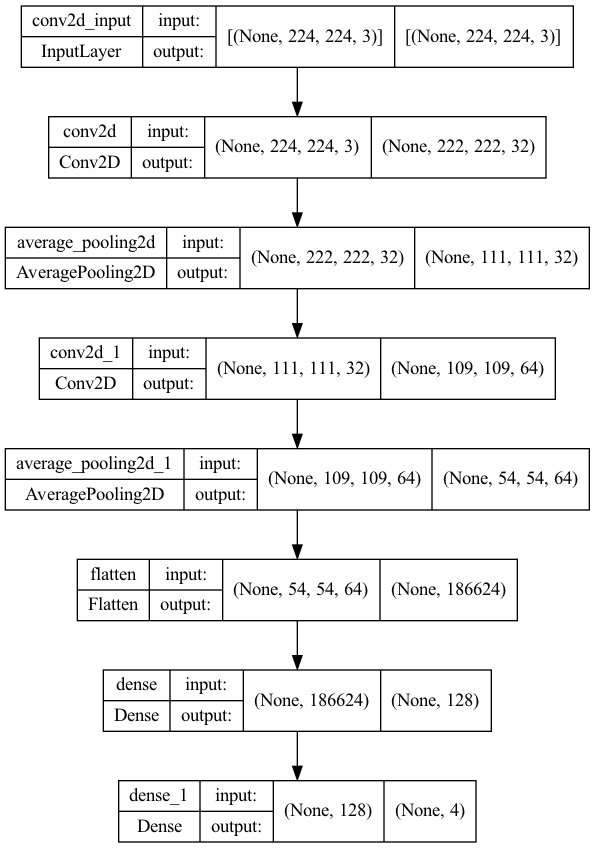

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
